In [5]:
import tar_nii_extraction
import random
import os
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from scipy import ndimage

In [6]:
#gpu
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.test.is_gpu_available(cuda_only=True, min_cuda_compute_capability=None)
#config = tf.ConfigProto()
#config.gpu_options.allow_growth=True
#sess = tf.Session(config=config)
# hard allocation
#gpus = tf.config.list_physical_devices('GPU')
#print(gpus)
#if gpus:
#    for gpu in gpus:
#        tf.config.experimental.set_virtual_device_configuration(gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
#memory growth
#gpus = tf.config.list_physical_devices('GPU')
#if gpus:
#    for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu,True)




IMAGE_ID=00376:	NORMAL_SCAN	[SLICE 80 FROM MRI SCAN] 


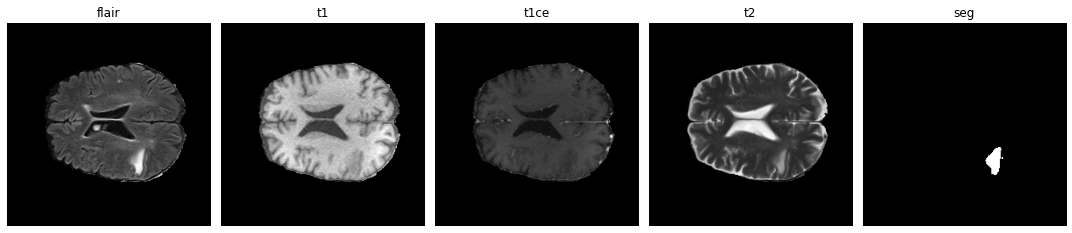




IMAGE_ID=00321:	ABNORMAL_SCAN	[SLICE 80 FROM MRI SCAN] 


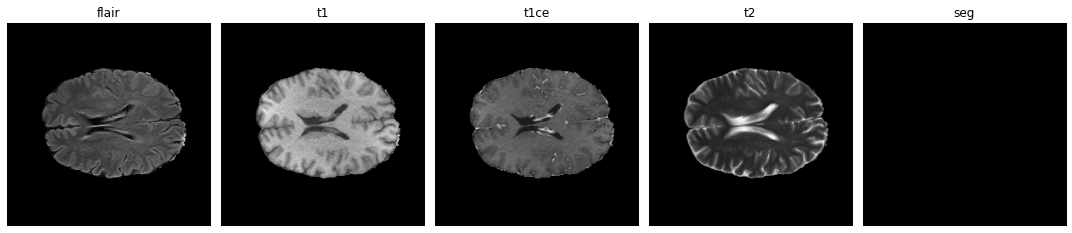

In [7]:
# Load Competition Training Dataframe
# Load training labels
train_df = pd.read_csv("./train_labels.csv")
scan_types = ["flair", "t1", "t1ce", "t2", "seg"]

# Visualizer function for scans
def visualizer(img_ids, scan_slice, train_df=train_df):
    for img_id in img_ids:
        # From training labels
        indicator = "NORMAL" if train_df[train_df['BraTS21ID']==int(img_id)].MGMT_value.values[0] == 0 else "ABNORMAL"
        print(f"\n\n\nIMAGE_ID={img_id}:\t{indicator}_SCAN\t[SLICE {scan_slice} FROM MRI SCAN] ")

        # Plot all scan types of requested slice for current ID
        plt.figure(figsize=(15, 10))
        for i, nii in enumerate([f'../../project_data/BraTS2021_{img_id}/BraTS2021_{img_id}_{scan_type}.nii.gz'
                                 for scan_type in scan_types]):
            plt.subplot(1,5,i+1)
            image = nib.load(nii).get_fdata()
            plt.title(nii.rsplit("_", 1)[1].split(".", 1)[0])
            plt.axis(False)
            plt.imshow(image[:, :, scan_slice], cmap="gray")

        plt.tight_layout()
        plt.show()

# Dataset access check
file_found = False
while not file_found:
    try:
        visualizer(["00376", "00321"], 80)
        file_found = True
    except FileNotFoundError:
        tar_nii_extraction.load_data()


In [8]:
img_ids = ["00376", "00789", "00441", "00703", "00807", "00523", "00241", "00778",]
SCAN_NUM = 83


In [9]:
# Source: https://keras.io/examples/vision/3D_image_classification/
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = 0
    max = 2500
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)

    # Normalize
    volume = normalize(volume)

    # Resize width, height and depth
    volume = resize_volume(volume)

    return volume

In [10]:
# Loop through train_df and get all ids for 0 and 1 respectively
ids_normal = train_df[train_df["MGMT_value"]==0].BraTS21ID
ids_abnormal = train_df[train_df["MGMT_value"]==1].BraTS21ID

ids_normal = [str(x).zfill(5) for x in ids_normal]
ids_abnormal = [str(x).zfill(5) for x in ids_abnormal]

print(f"{len(ids_normal)}, {len(ids_abnormal)}")


278, 307


In [11]:
# TODO: make these paths os agnostic. I know it's easy I just don't care rn
SCAN_TYPE = "flair"

normal_scan_paths = [
    os.path.join(os.getcwd(), f"..\..\project_data\BraTS2021_{x}\BraTS2021_{x}_{SCAN_TYPE}.nii.gz")
    for x in ids_normal
]


abnormal_scan_paths = [
    os.path.join(os.getcwd(), f"..\..\project_data\BraTS2021_{x}\BraTS2021_{x}_{SCAN_TYPE}.nii.gz")
    for x in ids_abnormal
]

# Some issues were found in the BraTS dataset and were removed
# The following loops remove paths that no longer exist
for path in normal_scan_paths:
    if not os.path.exists(path):
        normal_scan_paths.remove(path)
for path in abnormal_scan_paths:
    if not os.path.exists(path):
        abnormal_scan_paths.remove(path)

print("MRI scans with normal brain tissue: " + str(len(normal_scan_paths)))
print("MRI scans with abnormal brain tissue: " + str(len(abnormal_scan_paths)))


MRI scans with normal brain tissue: 276
MRI scans with abnormal brain tissue: 301


In [12]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])

In [13]:
# For the CT scans having presence of tumor
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

train_percent = 70
cut_point = int(len(abnormal_labels) * train_percent / 100)

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:cut_point], normal_scans[:cut_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:cut_point], normal_labels[:cut_point]), axis=0)
x_val = np.concatenate((abnormal_scans[cut_point:], normal_scans[cut_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[cut_point:], normal_labels[cut_point:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 420 and 157.


In [14]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""
    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [15]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 1
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the MRI scan is: (128, 128, 64, 1)
8.5885s


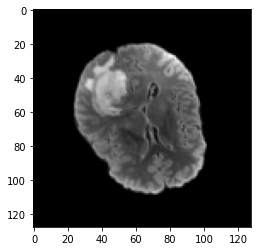

In [16]:
st=time.time()
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")
et=time.time()
print("{:.4f}s".format(et-st))

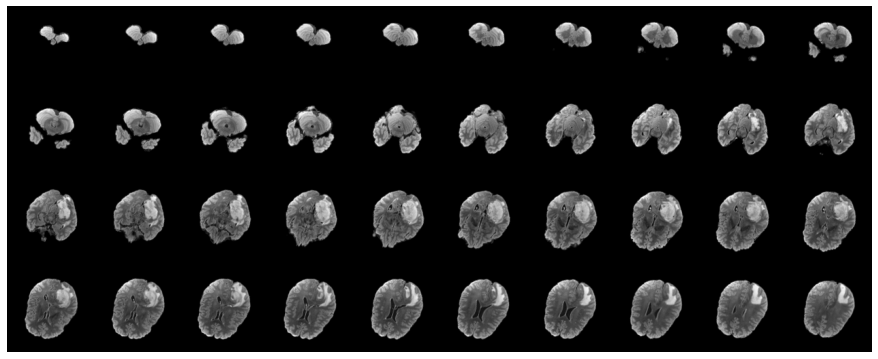

1.4257s


In [17]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    #cp.cuda.Stream.null.synchronize()
    data = np.transpose(data)
    #cp.cuda.Stream.null.synchronize()
    data = np.reshape(data, (num_rows, num_columns, width, height))
    #cp.cuda.Stream.null.synchronize()
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [18]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)


    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()


Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 32)  896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 32)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 32)    128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256   

In [19]:
# Compile model.
initial_learning_rate = 0.005
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 20
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],
)
model.save('./saved_model')

Epoch 1/20
420/420 [==============================] - 78s 161ms/step - loss: 0.7494 - acc: 0.5143 - val_loss: 0.8423 - val_acc: 0.4204

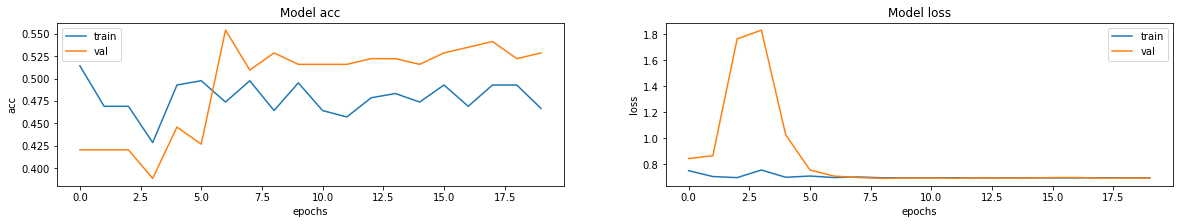

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [21]:
st=time.time()
# Load best weights.
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 40.03 percent confident that CT scan is normal
This model is 59.97 percent confident that CT scan is abnormal
